In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

In [2]:
def stock_trading_strategy(stock_price_df, start_date, end_date, initial_cash, investment, buy_threshold=0.05, sell_threshold=0.05, multiplier=1):
    # initialize variables
    num_shares = []
    total_cash = []
    num_shares_purchased = []
    num_shares_sold = []
    batches = []
    action = []
    action_date = []
    stock_price = []
    purchase_sell_action = []
    curr_cash = initial_cash
    # loop through each day in the dataframe
    stock_action_df = stock_price_df[stock_price_df['date'].between(start_date, end_date)]
    initial_price = stock_action_df.iloc[0]['daily_price']
    for i in range(len(stock_action_df)):
        # get the current price and date
        curr_price = stock_action_df.iloc[i]['daily_price']
        curr_date = stock_action_df.iloc[i]['date']
        action_date.append(curr_date)
        stock_price.append(curr_price)

        # check if we should purchase, sell, or pass
        if len(batches) == 0 or curr_price <= batches[-1][0] * (1-buy_threshold):
            if curr_price > initial_price:
                # pass
                action.append('Pass')
                num_shares_purchased.append(0)
                num_shares_sold.append(0)
                total_cash.append(total_cash[-1])
                num_shares.append(num_shares[-1])
            else:
                if len(purchase_sell_action) == 0:
                    pass
                elif purchase_sell_action[-1] == 'Purchase':
                    # increase investment amount at each purchase if the price keeps dropping
                    investment = investment * multiplier
                elif purchase_sell_action[-1] == 'Sell' and purchase_sell_action[-2] == 'Sell':
                    # reset investment amount as price begins to increase
                    investment = investment / multiplier
                else:
                    pass
                # purchase
                num_shares_to_purchase = min(curr_cash, investment) / curr_price
                if len(num_shares) == 0:
                    num_shares.append(num_shares_to_purchase)
                else:
                    num_shares.append(num_shares[-1] + num_shares_to_purchase)
                if len(total_cash) == 0:
                    total_cash.append(initial_cash - min(curr_cash, investment))
                else:
                    total_cash.append(total_cash[-1] - min(curr_cash, investment))
                batches.append((curr_price, num_shares_to_purchase))
                action.append('Purchase')
                purchase_sell_action.append('Purchase')
                num_shares_purchased.append(num_shares_to_purchase)
                num_shares_sold.append(0)
                curr_cash -= min(curr_cash, investment)
        elif curr_price >= batches[-1][0] * (1+sell_threshold):
            # sell
            num_shares_to_sell = batches[-1][1]
            num_shares.append(num_shares[-1] - num_shares_to_sell)
            total_cash.append(total_cash[-1] + num_shares_to_sell * curr_price)
            batches.pop()
            # this batch is sold
            action.append('Sell')
            purchase_sell_action.append('Sell')
            num_shares_purchased.append(0)
            num_shares_sold.append(num_shares_to_sell)
            curr_cash += num_shares_to_sell * curr_price
        else:
            # pass
            action.append('Pass')
            num_shares_purchased.append(0)
            num_shares_sold.append(0)
            total_cash.append(total_cash[-1])
            num_shares.append(num_shares[-1])

        
        # add the results to a new dataframe row
        results_df = pd.DataFrame({
            'date': action_date,
            'daily_price':stock_price,
            'action': action,
            'num_shares_purchased': num_shares_purchased,
            'purchase_value':np.array(stock_price)*np.array(num_shares_purchased),
            'num_shares_sold': num_shares_sold,
            'sell_value':np.array(stock_price)*np.array(num_shares_sold),
            'total_num_shares': num_shares,
            'total_stock_value':np.array(stock_price)*np.array(num_shares),
            'total_cash': total_cash
        })
        
        # concatenate the new row to the overall results dataframe
    return results_df

In [3]:
def plot_trading_strategy(df_stock, result):
    # plot the daily stock prices as a curve
    plt.figure(figsize=(16, 8))
    plt.plot(df_stock['date'], df_stock['daily_price'], label='Stock Price')


    # plot the purchase actions as red dots
    purchases = result[result['action'] == 'Purchase']
    plt.scatter(purchases['date'], purchases['daily_price'], color='red', label='Purchase')

    for index, row in purchases.iterrows():
        # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
        plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                     xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

    # plot the sell actions as blue dots
    sells = result[result['action'] == 'Sell']
    plt.scatter(sells['date'], sells['daily_price'], color='blue', label='Sell')


    for index, row in sells.iterrows():
        # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
        plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                     xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Trading Strategy Visualization')
    plt.legend()

    plt.show()

In [4]:
def download_stock_df(stock_name, start_date='2018-01-01', end_date=datetime.today().strftime('%Y-%m-%d'), price='Open'):
    '''
    Download the daily stock price from Yahoo Finance as a dataframe
    
    Input:
    stock_name: string, stock name
    start_date: string, 'YYYY-MM-DD' format of date specifying the date range
    end_date: string, 'YYYY-MM-DD' format of date specifying the date range
    price: 'Open' or 'Close', specifying which stock price is output to the result dataframe
    
    Output:
    df_stock_price: dataframe, with two columns: date, daily_price
        where daily_price is the stock open price by default
    '''
    # Download historical data from Yahoo Finance for AAPL
    data = yf.download(stock_name.upper(), start=start_date, end=end_date)
    # Extract the daily closing prices and reset the index
    df_stock_price = data[[price]].reset_index()
    # Rename the columns to match the desired format
    df_stock_price.columns = ['date', 'daily_price']
    # Ensure daily_price is non-negative
    df_stock_price['daily_price'] = df_stock_price['daily_price'].clip(lower=0)
    return df_stock_price

In [9]:
# Create a user function
def user_function():
    stock_name = (input('Enter the stock name:')).upper()
    start_date = input('Enter the strategy start date, in YYYY-MM-DD format (default: %s):' % ((datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'))) or ((datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'))
    end_date = input('Enter the strategy end date, in YYYY-MM-DD format (default: %s):' % (datetime.today().strftime('%Y-%m-%d'))) or (datetime.today().strftime('%Y-%m-%d'))
    customerize_ind = input('Would you like to customerize the strategy parameters? Enter Y for yes; otherwise would use default value')
    if customerize_ind.upper() == 'Y':
        initial_cash = float(input('Enter the initial cash (default: %s):' % ('10000')) or (10000))
        investment = float(input('Enter the investment amount for each purchase (default: %s):' % ('1000')) or (1000))
        buy_threshold = int(input('If the stock price drops X percent, make a purchase. Enter X as an integer (default: %s):' % ('5')) or 5) / 100
        sell_threshold = int(input('If the stock price rises X percent, make a sell. Enter X as an integer (default: %s):' % ('5')) or 5) / 100
    else:
        initial_cash = 10000
        investment = 1000
        buy_threshold = 0.05
        sell_threshold = 0.05
    stock_df = download_stock_df(stock_name)
    result = stock_trading_strategy(stock_df, start_date, end_date,initial_cash, investment, buy_threshold=buy_threshold, sell_threshold=sell_threshold, multiplier=1)
    print('Strategy specifics:')
    print('    stock name: %s' %(stock_name))
    print('    strategy start date: %s, strategy end date: %s' %(start_date, end_date))
    print('    initial cash: %s, each investment: %s, buy_threshold: %s, sell_threshold: %s' %(initial_cash, investment, buy_threshold, sell_threshold))
    print('\n')
    print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
    print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
    print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
    print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

    print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
    print('Minimal Cash Reserved: ', result['total_cash'].min())
    print('\n')
    print('Transaction samples:')
    print(result[result['action'].isin(['Purchase','Sell'])].head())
    plot_trading_strategy(stock_df, result)

Enter the stock name:msft
Enter the strategy start date, in YYYY-MM-DD format (default: 2022-05-11):
Enter the strategy end date, in YYYY-MM-DD format (default: 2023-05-11):
Would you like to customerize the strategy parameters? Enter Y for yes; otherwise would use default value
[*********************100%***********************]  1 of 1 completed
Strategy specifics:
    stock name: MSFT
    strategy start date: 2022-05-11, strategy end date: 2023-05-11
    initial cash: 10000, each investment: 1000, buy_threshold: 0.05, sell_threshold: 0.05


Final Profit: 722.2618284076652
Underlying stock price change: 15.07%
Max Profit ever: 722.2618284076652
Max Loss ever: -174.98388201508533
Number of Purchase & Sell actions: 22
Minimal Cash Reserved:  6188.961374800267


Transaction samples:
         date  daily_price    action  num_shares_purchased  purchase_value   
0  2022-05-11   265.679993  Purchase              3.763927          1000.0  \
22 2022-06-13   245.110001  Purchase              4.

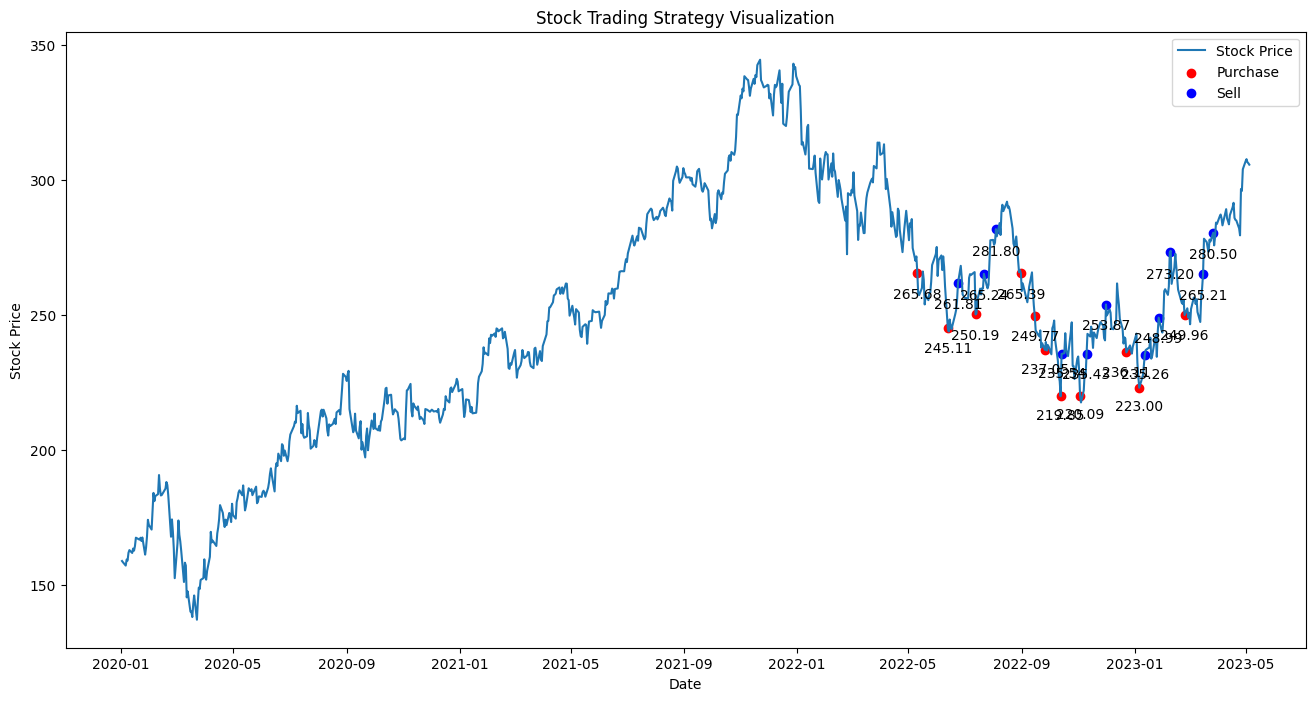

In [7]:
user_function()

In [49]:
def test_sp500(th1, th2, m):
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    symbols = sp500.Symbol.to_list()
    today_date = datetime.today().strftime('%Y-%m-%d')
    initial_cash = 10000
    investment = 1000
    list_stock = []
    list_profit = []
    list_max_loss = []
    list_number_actions = []
    list_minimal_cash_reserve = []
    list_price_change = []
    for stock_name in symbols:
        stock_df = download_stock_df(stock_name)
        try:
            result = stock_trading_strategy(stock_df, '2018-01-01', today_date, initial_cash, investment, th1, th2, m)
            profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
            underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
            max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
            number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
            minimal_cash_reserve = result['total_cash'].min()
            list_stock.append(stock_name)
            list_profit.append(profit)
            list_price_change.append(underlying_stock_price_change)
            list_max_loss.append(max_loss)
            list_minimal_cash_reserve.append(minimal_cash_reserve)
            list_number_actions.append(number_actions)
        except:
            print('error with ', stock_name)
            symbols.remove(stock_name)
        
    try_remove_list = [e for e in sp500.Symbol.to_list() if e not in list_stock]
    for stock_name in try_remove_list:
        stock_name = stock_name.replace('.','-')
        try:
            result = stock_trading_strategy(stock_df, '2018-01-01', today_date, initial_cash, investment, th1, th2, m)
            profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
            underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
            max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
            number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
            minimal_cash_reserve = result['total_cash'].min()
            list_stock.append(stock_name)
            list_profit.append(profit)
            list_price_change.append(underlying_stock_price_change)
            list_max_loss.append(max_loss)
            list_minimal_cash_reserve.append(minimal_cash_reserve)
            list_number_actions.append(number_actions)
        except:
            print('error with ', stock_name)
            try_remove_list.remove(stock_name)

    df_all_stock = pd.DataFrame(
        {
            'stock_name': list_stock,
            'start_date': ['2018-01-01']*len(list_stock),
            'end_date': [today_date]*len(list_stock),
            'initial_cash': [initial_cash]*len(list_stock),
            'investment': [investment]*len(list_stock),
            'buy_threshold': [th1]*len(list_stock),
            'sell_threshold': [th2]*len(list_stock),
            'profit': list_profit,
            'underlying_stock_price_change': list_price_change,
            'max_loss': list_max_loss,
            'minimal_cash_reserve': list_minimal_cash_reserve,
            'number_actions': list_number_actions
        }
    )
    print('Numbers of stock tested:', len(list_stock)+len(try_remove_list))
    print(df_all_stock.shape)
    return df_all_stock

In [24]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
symbols = sp500.Symbol.to_list()
today_date = datetime.today().strftime('%Y-%m-%d')
initial_cash = 10000
investment = 1000
th1 = 0.05
th2 = 0.05
list_stock = []
list_profit = []
list_max_loss = []
list_number_actions = []
list_minimal_cash_reserve = []
list_price_change = []
for stock_name in symbols:
    stock_df = download_stock_df(stock_name)
    try:
        result = stock_trading_strategy(stock_df, '2018-01-01', today_date, initial_cash, investment, th1, th2)
        profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
        underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
        max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
        number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
        minimal_cash_reserve = result['total_cash'].min()
        list_stock.append(stock_name)
        list_profit.append(profit)
        list_price_change.append(underlying_stock_price_change)
        list_max_loss.append(max_loss)
        list_minimal_cash_reserve.append(minimal_cash_reserve)
        list_number_actions.append(number_actions)
    except:
        print('error with ', stock_name)
        symbols.remove(stock_name)
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [26]:
df_all_stock = pd.DataFrame(
    {
        'stock_name': list_stock,
        'start_date': ['2018-01-01']*len(list_stock),
        'end_date': [today_date]*len(list_stock),
        'initial_cash': [initial_cash]*len(list_stock),
        'investment': [investment]*len(list_stock),
        'buy_threshold': [th1]*len(list_stock),
        'sell_threshold': [th2]*len(list_stock),
        'profit': list_profit,
        'underlying_stock_price_change': list_price_change,
        'max_loss': list_max_loss,
        'minimal_cash_reserve': list_minimal_cash_reserve,
        'number_actions': list_number_actions
    }
)
print('Numbers of stock tested:', len(symbols))
print(df_all_stock.shape)
df_all_stock.head()

Numbers of stock tested: 501
(499, 12)


,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
0,MMM,2018-01-01,2023-05-12,10000,1000,0.05,0.05,-609.882795,-0.421432,-1050.236856,2225.779480,51
1,AOS,2018-01-01,2023-05-12,10000,1000,0.05,0.05,892.788393,0.461073,-599.367720,5191.194121,28
2,ABT,2018-01-01,2023-05-12,10000,1000,0.05,0.05,626.144051,0.294097,-316.622828,6272.048452,18
3,ABBV,2018-01-01,2023-05-12,10000,1000,0.05,0.05,698.942980,0.667490,-344.269699,6277.779801,22
4,ACN,2018-01-01,2023-05-12,10000,1000,0.05,0.05,607.673105,0.276771,-841.447910,5052.757184,18


In [29]:
list_profit = []
list_max_loss = []
list_number_actions = []
list_minimal_cash_reserve = []
list_price_change = []
try_remove_list = [e for e in sp500.Symbol.to_list() if e not in list_stock]
for stock_name in try_remove_list:
    stock_name = stock_name.replace('.','-')
    try:
        result = stock_trading_strategy(stock_df, '2018-01-01', today_date, initial_cash, investment, th1, th2)
        profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
        underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
        max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
        number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
        minimal_cash_reserve = result['total_cash'].min()
        list_profit.append(profit)
        list_price_change.append(underlying_stock_price_change)
        list_max_loss.append(max_loss)
        list_minimal_cash_reserve.append(minimal_cash_reserve)
        list_number_actions.append(number_actions)
    except:
        print('error with ', stock_name)
        try_remove_list.remove(stock_name)
        
df_all_stock = pd.concat([df_all_stock, 
                          pd.DataFrame(
                              {
                                  'stock_name': try_remove_list,
                                  'start_date': ['2018-01-01']*len(try_remove_list),
                                  'end_date': [today_date]*len(try_remove_list),
                                  'initial_cash': [initial_cash]*len(try_remove_list),
                                  'investment': [investment]*len(try_remove_list),
                                  'buy_threshold': [th1]*len(try_remove_list),
                                  'sell_threshold': [th2]*len(try_remove_list),
                                  'profit': list_profit,
                                  'underlying_stock_price_change': list_price_change,
                                  'max_loss': list_max_loss,
                                  'minimal_cash_reserve': list_minimal_cash_reserve,
                                  'number_actions': list_number_actions
                              }
                          )
                         ]
                        )
print('Numbers of stock tested:', len(list_stock)+len(try_remove_list))
print(df_all_stock.shape)
df_all_stock.head()

Numbers of stock tested: 503
(503, 12)


,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
0,MMM,2018-01-01,2023-05-12,10000,1000,0.05,0.05,-609.882795,-0.421432,-1050.236856,2225.779480,51
1,AOS,2018-01-01,2023-05-12,10000,1000,0.05,0.05,892.788393,0.461073,-599.367720,5191.194121,28
2,ABT,2018-01-01,2023-05-12,10000,1000,0.05,0.05,626.144051,0.294097,-316.622828,6272.048452,18
3,ABBV,2018-01-01,2023-05-12,10000,1000,0.05,0.05,698.942980,0.667490,-344.269699,6277.779801,22
4,ACN,2018-01-01,2023-05-12,10000,1000,0.05,0.05,607.673105,0.276771,-841.447910,5052.757184,18


In [36]:
df_all_stock[df_all_stock['max_loss']>=-1000].sort_values(by=['profit'], ascending=False)

,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.05,4443.455749,0.049321,-122.204254,4441.987316,82
97,CDAY,2018-01-01,2023-05-12,10000,1000,0.05,0.05,3355.349819,-0.155049,-934.471224,4219.852976,97
369,PCG,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2551.466644,0.576535,-133.693777,6999.757221,68
199,FISV,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2520.992546,0.022328,-569.878013,5179.218031,82
314,MU,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2345.146849,0.105014,-422.484658,6276.031766,66
...,...,...,...,...,...,...,...,...,...,...,...,...
441,TSLA,2018-01-01,2023-05-12,10000,1000,0.05,0.05,213.404012,4.793993,0.000000,9000.000000,4
402,ROL,2018-01-01,2023-05-12,10000,1000,0.05,0.05,126.805501,0.887184,-7.521030,9000.000000,4
396,REGN,2018-01-01,2023-05-12,10000,1000,0.05,0.05,122.538809,0.994392,-142.132427,8000.000000,4
431,TMUS,2018-01-01,2023-05-12,10000,1000,0.05,0.05,110.534498,0.793864,-10.395534,9000.000000,4


In [42]:
df_all_stock[(df_all_stock['profit']>0) & (df_all_stock['max_loss']>=-1000)].shape[0]/df_all_stock.shape[0]

0.4831013916500994

In [44]:
df_all_stock[(df_all_stock['profit']>2500) & (df_all_stock['max_loss']>=-1000)].shape[0]/df_all_stock.shape[0]

0.007952286282306162

In [45]:
df_all_stock[(df_all_stock['profit']>2500) & (df_all_stock['max_loss']>=-1000)]

,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.05,4443.455749,0.049321,-122.204254,4441.987316,82
97,CDAY,2018-01-01,2023-05-12,10000,1000,0.05,0.05,3355.349819,-0.155049,-934.471224,4219.852976,97
199,FISV,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2520.992546,0.022328,-569.878013,5179.218031,82
369,PCG,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2551.466644,0.576535,-133.693777,6999.757221,68


In [46]:
df_all_stock[(df_all_stock['profit']>df_all_stock['underlying_stock_price_change']*10000) & (df_all_stock['max_loss']>=-1000)].shape[0]/df_all_stock.shape[0]

0.15705765407554673

In [47]:
df_all_stock[(df_all_stock['profit']>df_all_stock['underlying_stock_price_change']*10000) & (df_all_stock['max_loss']>=-1000)]

,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
7,ADBE,2018-01-01,2023-05-12,10000,1000,0.05,0.05,1065.685840,0.027212,-5.181792,7411.191480,32
14,AKAM,2018-01-01,2023-05-12,10000,1000,0.05,0.05,645.202216,-0.109051,-4.606102,7421.677544,24
17,ARE,2018-01-01,2023-05-12,10000,1000,0.05,0.05,1146.799424,-0.241771,-586.396924,5110.875016,60
19,ALLE,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2318.103459,-0.133905,-714.872809,5209.899428,77
20,LNT,2018-01-01,2023-05-12,10000,1000,0.05,0.05,1128.013342,-0.016642,-433.769618,6108.596034,41
...,...,...,...,...,...,...,...,...,...,...,...,...
433,TTWO,2018-01-01,2023-05-12,10000,1000,0.05,0.05,1610.159800,-0.025338,-154.478081,7064.113966,51
455,UDR,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2022.019202,-0.133562,-859.372042,4099.413560,67
480,WEC,2018-01-01,2023-05-12,10000,1000,0.05,0.05,1564.333586,0.026948,-78.695025,7820.683314,48
489,WTW,2018-01-01,2023-05-12,10000,1000,0.05,0.05,1163.266986,0.110613,-670.891036,5109.434409,36


In [50]:
strategy_dfs = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_sp500(th1, th2, m)
            strategy_dfs.append(df_strategy)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
error with  BF.B
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No timezone found, symbol may be delisted
error with  BRK.B
[*********************100%***********************]  1 of 1 completed
[*************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Numbers of stock tested: 507
(503, 12)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 compl

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [53]:
good_dfs = []
for df in strategy_dfs:
    good_dfs.append(df[(df['profit']>=2500)&(df['max_loss']>=-1000)])
good_df = pd.concat(good_dfs)
print(good_df.shape)
good_df.head()

(96, 12)


,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.05,4443.455749,0.049321,-122.204254,4441.987316,82
97,CDAY,2018-01-01,2023-05-12,10000,1000,0.05,0.05,3355.349819,-0.155049,-934.471224,4219.852976,97
193,FISV,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2520.992546,0.022328,-569.878013,5179.218031,82
363,PCG,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2551.466644,0.576535,-133.693777,6999.757221,68
19,ALLE,2018-01-01,2023-05-12,10000,1000,0.05,0.05,2733.481320,-0.133905,-748.455251,4700.454334,77


In [58]:
good_df.sort_values(by='profit', ascending=False)

,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.30,5451.577906,0.049321,-374.116015,2220.089480,22
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.05,5415.342089,0.049321,-123.557895,2620.073435,82
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.10,5186.625711,0.049321,-123.557895,2722.755184,47
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.15,4520.473621,0.049321,-123.557895,2807.602721,34
67,BIIB,2018-01-01,2023-05-12,10000,1000,0.05,0.30,4452.042985,0.049321,-361.828408,4497.868910,22
...,...,...,...,...,...,...,...,...,...,...,...,...
89,CTLT,2018-01-01,2023-05-12,10000,1000,0.10,0.30,2519.055042,-0.120976,-715.669042,6000.000000,14
297,MKTX,2018-01-01,2023-05-12,10000,1000,0.07,0.30,2513.252531,-0.214459,-525.693908,4057.955672,17
207,BEN,2018-01-01,2023-05-12,10000,1000,0.07,0.05,2511.850276,-0.005076,-981.345641,4529.815843,61
410,STX,2018-01-01,2023-05-12,10000,1000,0.05,0.30,2506.215276,-0.065207,-985.347212,5000.000000,18


In [55]:
good_df['max_loss'].max(),good_df['max_loss'].min()

(-58.6617230613665, -995.4322307388375)

In [57]:
params = ['buy_threshold','sell_threshold']
good_df.groupby(params).agg({'profit': ['min','max','mean'], 'max_loss': ['min','max','mean']})

profit                             
                                      min          max         mean   
buy_threshold sell_threshold                                          
0.05          0.05            2520.992546  5415.342089  3124.395410  \
              0.10            2536.397362  5186.625711  3481.691452   
              0.15            2537.067844  4520.473621  3386.200790   
              0.30            2506.215276  5451.577906  3331.021536   
0.07          0.05            2511.850276  4110.930263  3235.933658   
              0.10            2711.118851  3886.681569  3125.220112   
              0.15            2531.107316  3826.572508  3133.619824   
              0.30            2513.252531  3911.024803  2900.721613   
0.10          0.05            3257.162965  3257.162965  3257.162965   
              0.10            2505.255972  3050.263389  2703.955864   
              0.15            2598.919845  3349.633027  2921.012102   
              0.30            2519.055042  4204.898427  3083.096252   

                                max_loss                          
                                     min         max        mean  
buy_threshold sell_threshold                                      
0.05          0.05           -934.471224 -122.204254 -513.521889  
              0.10           -887.513648  -58.661723 -491.218655  
              0.15           -905.116852  -58.661723 -500.251710  
              0.30           -985.347212  -58.661723 -501.723246  
0.07          0.05           -994.785063 -114.944556 -612.917062  
              0.10           -848.981839 -114.944556 -406.147136  
              0.15           -908.107057 -114.944556 -406.022428  
              0.30           -995.432231 -188.530441 -651.520545  
0.10          0.05           -994.785063 -994.785063 -994.785063  
              0.10           -945.878587  -95.131453 -746.162897  
              0.15           -902.043057  -95.131453 -612.657157  
              0.30           -995.432231 -242.571876 -664.450739

In [60]:
good_df[good_df['stock_name']=='SBUX']

,stock_name,start_date,end_date,initial_cash,investment,buy_threshold,sell_threshold,profit,underlying_stock_price_change,max_loss,minimal_cash_reserve,number_actions
423,SBUX,2018-01-01,2023-05-12,10000,1000,0.07,0.3,2903.756225,0.197798,-995.432231,5000.0,18
421,SBUX,2018-01-01,2023-05-12,10000,1000,0.10,0.3,2602.636275,0.197798,-995.432231,5000.0,16


In [64]:
pd.concat(strategy_dfs).to_csv('~/Documents/data/trading_strategy/sp500_stock_strategy.csv', index=False)

Enter the stock name:xlf
Enter the strategy start date, in YYYY-MM-DD format (default: 2022-06-13):
Enter the strategy end date, in YYYY-MM-DD format (default: 2023-06-13):
Would you like to customerize the strategy parameters? Enter Y for yes; otherwise would use default valuey
Enter the initial cash (default: 10000):
Enter the investment amount for each purchase (default: 1000):
If the stock price drops X percent, make a purchase. Enter X as an integer (default: 5):
If the stock price rises X percent, make a sell. Enter X as an integer (default: 5):10
[*********************100%***********************]  1 of 1 completed
Strategy specifics:
    stock name: XLF
    strategy start date: 2022-06-13, strategy end date: 2023-06-13
    initial cash: 10000.0, each investment: 1000.0, buy_threshold: 0.05, sell_threshold: 0.1


Final Profit: 276.4231208331166
Underlying stock price change: 4.64%
Max Profit ever: 281.206332662181
Max Loss ever: -31.851099044268267
Number of Purchase & Sell actio

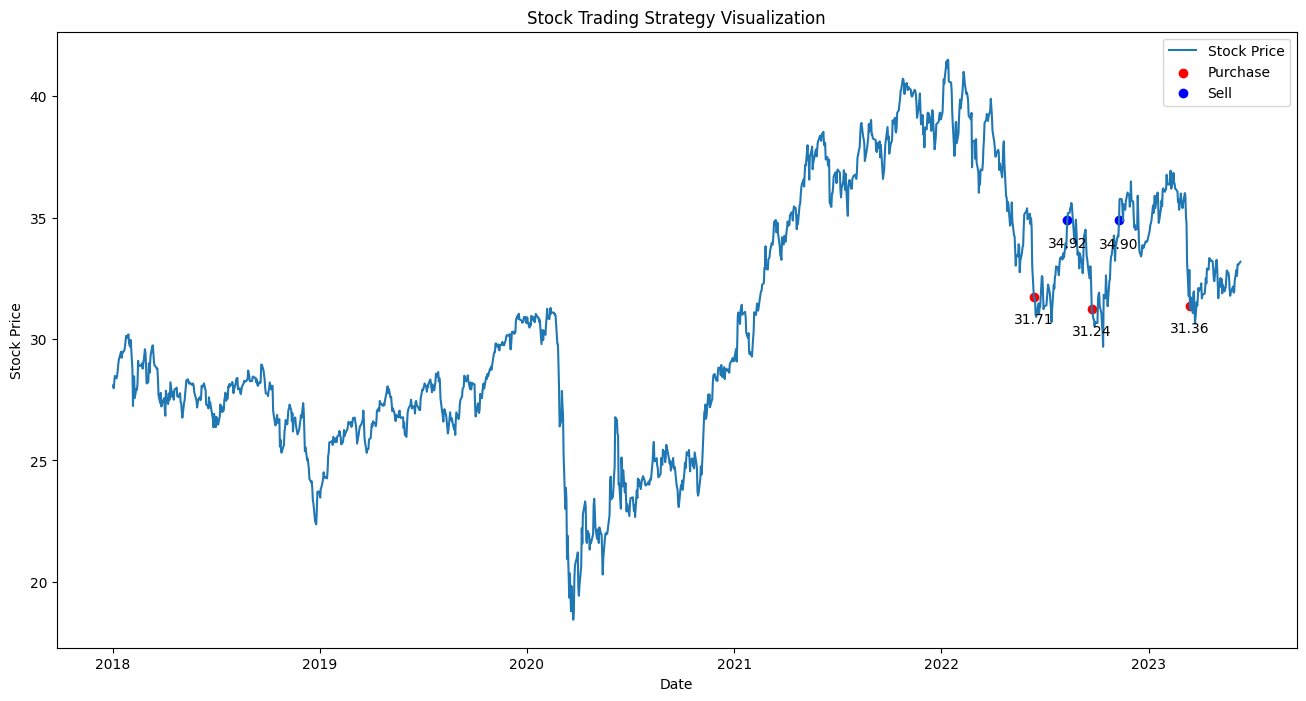

In [12]:
user_function()

Enter the stock name:xle
Enter the strategy start date, in YYYY-MM-DD format (default: 2022-06-13):2022-06-16
Enter the strategy end date, in YYYY-MM-DD format (default: 2023-06-13):
Would you like to customerize the strategy parameters? Enter Y for yes; otherwise would use default valuey
Enter the initial cash (default: 10000):
Enter the investment amount for each purchase (default: 1000):
If the stock price drops X percent, make a purchase. Enter X as an integer (default: 5):
If the stock price rises X percent, make a sell. Enter X as an integer (default: 5):10
[*********************100%***********************]  1 of 1 completed
Strategy specifics:
    stock name: XLE
    strategy start date: 2022-06-16, strategy end date: 2023-06-13
    initial cash: 10000.0, each investment: 1000.0, buy_threshold: 0.05, sell_threshold: 0.1


Final Profit: 784.9325274001185
Underlying stock price change: -0.10%
Max Profit ever: 811.7316864773074
Max Loss ever: -319.7964036762369
Number of Purchase &

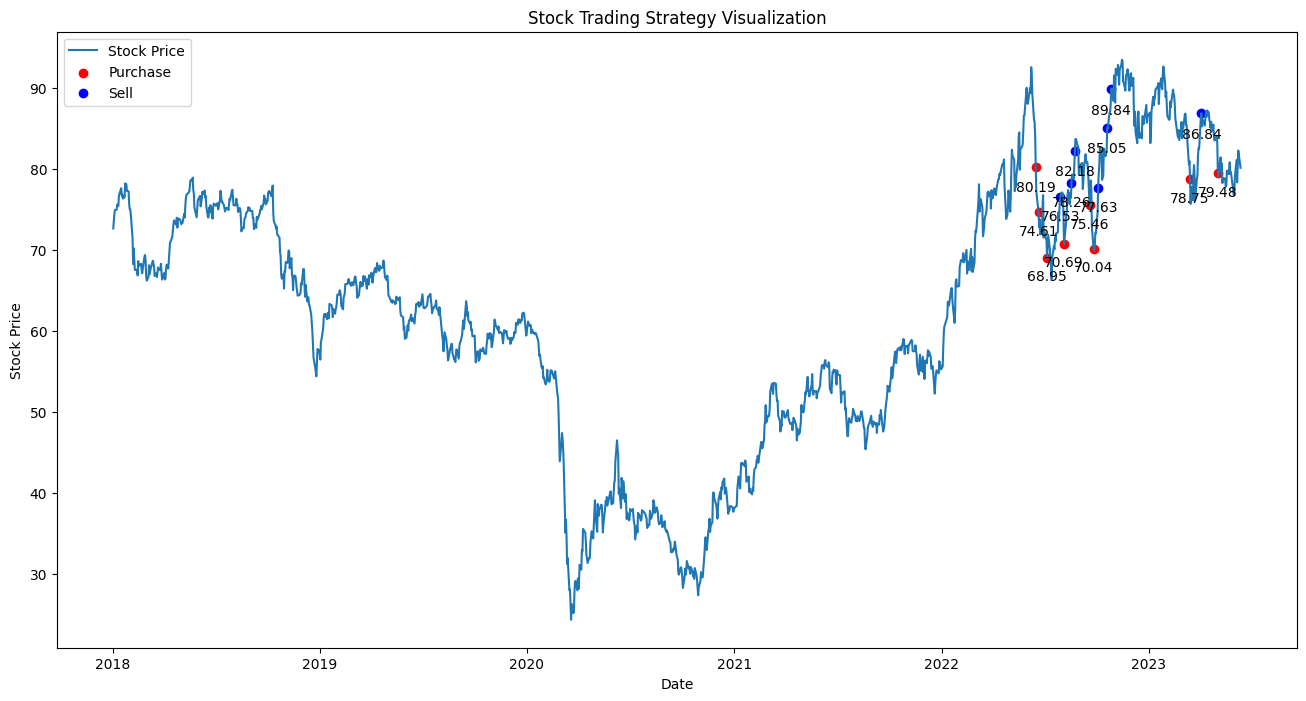

In [10]:
user_function()

Enter the stock name:xle
Enter the strategy start date, in YYYY-MM-DD format (default: 2022-06-13):2022-06-16
Enter the strategy end date, in YYYY-MM-DD format (default: 2023-06-13):
Would you like to customerize the strategy parameters? Enter Y for yes; otherwise would use default valuey
Enter the initial cash (default: 10000):
Enter the investment amount for each purchase (default: 1000):
If the stock price drops X percent, make a purchase. Enter X as an integer (default: 5):5
If the stock price rises X percent, make a sell. Enter X as an integer (default: 5):10
[*********************100%***********************]  1 of 1 completed
Strategy specifics:
    stock name: XLE
    strategy start date: 2022-06-16, strategy end date: 2023-06-13
    initial cash: 10000.0, each investment: 1000.0, buy_threshold: 0.05, sell_threshold: 0.1


Final Profit: 480.2064339499757
Underlying stock price change: -0.10%
Max Profit ever: 507.00559302716465
Max Loss ever: -319.7964036762369
Number of Purchase

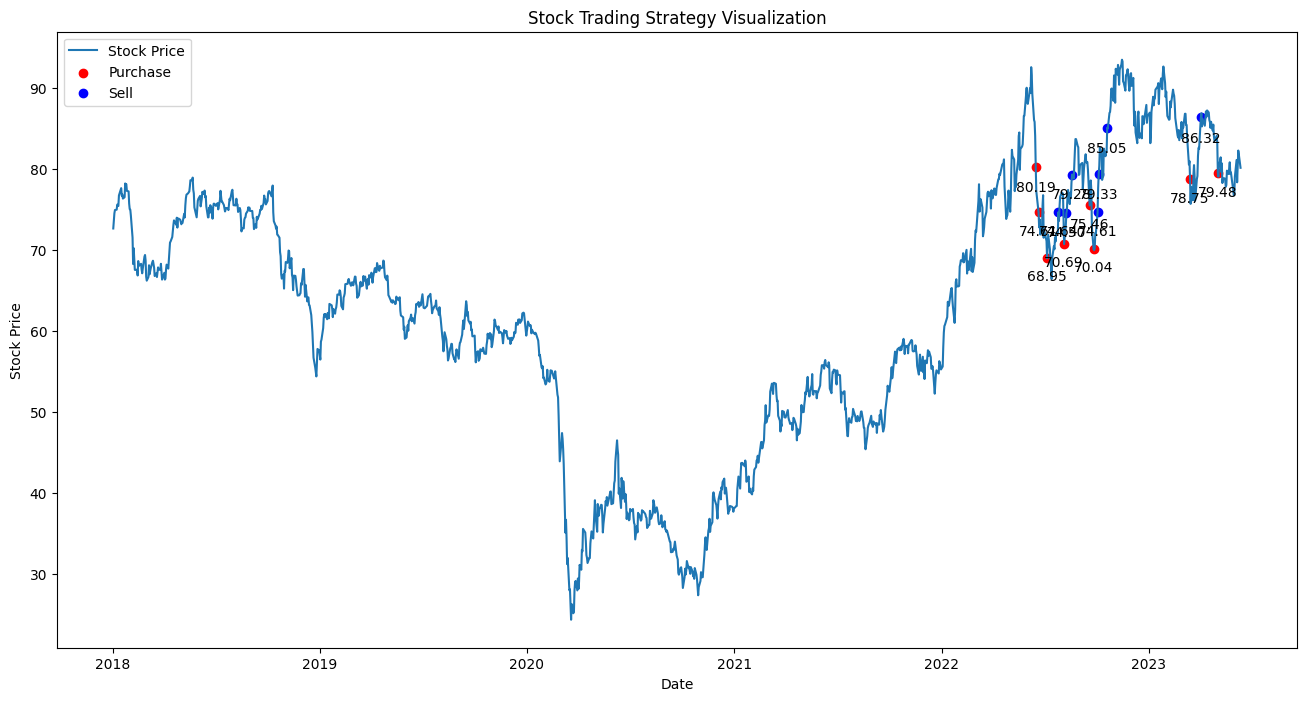

In [8]:
user_function()